In [6]:
import torch, os
import pandas as pd
import torch.nn as nn

from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
model = AutoModelForQuestionAnswering.from_pretrained("models/RoBERT.pth")
tokenizer = AutoTokenizer.from_pretrained("models/Tokenizer_RoBERT.pth/")

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at models/RoBERT.pth and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
class RoBERTa(nn.Module):
    def __init__(self, model):
        super(RoBERTa, self).__init__()
        self.RoBERTa = model.roberta
        self.qa_outputs = nn.Linear(in_features=768, out_features=2, bias=True)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        x = self.RoBERTa(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        x = self.qa_outputs(x.last_hidden_state)
        
        return {
            'start_logits': x[:, :, 0],
            'end_logits': x[:, :, 1]
        }

In [11]:
model = RoBERTa(model)

In [5]:
df = pd.read_csv("yerdaulet_annot.csv")

train, val = train_test_split(df, test_size=0.2)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

In [6]:
train_encodings = tokenizer(list(train.context), list(train.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

val_encodings = tokenizer(list(val.context), list(val.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

In [26]:
def add_token_positions(encodings, df):
    start_positions = []
    end_positions = []


    for i in range(len(df['start_position'])):
        target_answer = df.at[i, "answer"]
        start = encodings.char_to_token(i, df['start_position'][i] + 0)
        end = encodings.char_to_token(i, df['end_position'][i] + 0)

        if end is None:
            end = encodings.char_to_token(i, df['end_position'][i] + 1)
        
        answer = tokenizer.decode(encodings['input_ids'][i][start:end])
        
        if target_answer.strip() == answer.strip():
            pass
        else:
            counter = 2
            while end is None:
                end = encodings.char_to_token(i, df['end_position'][i] + counter)
                if counter == 50:
                    break
                    
                counter += 1

            counter = 1
            while end is None:
                end = encodings.char_to_token(i, df['end_position'][i] - counter)
                counter += 1

                
        start_positions.append(start)
        end_positions.append(end)
    
    encodings.update({
        'start_positions': start_positions,
        'end_positions': end_positions
    })

In [8]:
add_token_positions(train_encodings, train)
add_token_positions(val_encodings, val)

In [27]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        
    def __len__(self, ):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, x):
        return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}

In [10]:
vals = next(iter(SquadDataset(train_encodings)))

C:\Users\yerda\AppData\Local\Temp\ipykernel_5184\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}


In [11]:
vals['input_ids'];

In [12]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [13]:
def save_model(model_name, epoch, prev_loss, current_loss, model, tokenizer, optimizer):
    if prev_loss > current_loss:
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "tokenizer": "best_RoBERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/best_{model_name}.pt") # create models folder before! 
        print("The best model was saved!")
        prev_loss = current_loss
#         model.save_pretrained("models/best_RoBERTa_model.pth")
#         tokenizer.save_pretrained("models/best_RoBERT_tokenizer.pth")
    
    torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "tokenizer": "last_RoBERT_tokenizer.pth",
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/last_{model_name}.pt")
#     model.save_pretrained("models/last_RoBERTa_model.pth")
#     tokenizer.save_pretrained("models/last_RoBERT_tokenizer.pth")
    return prev_loss


os.makedirs("models", exist_ok=True)

In [13]:
class CrossNetropyLoss(nn.Module):
    def __init__(self,):
        super(CrossNetropyLoss, self).__init__()
        self.entropy = nn.CrossEntropyLoss() 
    
    def forward(self, x, start, end):
        return self.entropy(x['start_logits'], start) + self.entropy(x['end_logits'], end)

In [15]:
model.train()
model.to(device)
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = CrossNetropyLoss()

In [16]:
num_epochs, prev_loss = 100, torch.inf
train_loss, val_loss = [], []


for epoch in range(num_epochs):
    loop = tqdm(train_loader)
    loss_list, count = 0, 0
    for batch in loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        loss = criterion(outputs, start_positions, end_positions)
        loss.backward()
        optim.step()
        
        loss_list += loss.item()
        count += 1
        
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())
    
    loss = loss_list/count
    train_loss.append(loss)
    model.eval()
    @torch.no_grad()
    def validation():
        loop = tqdm(val_loader)
        loss_list, count = 0, 0
        for batch in loop:            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            
            loss = criterion(outputs, start_positions, end_positions)
            loss_list += loss.item()
            count += 1
            
            loop.set_description(f"Epoch {epoch}")
            loop.set_postfix(loss=loss.item())

        return loss_list / count
    v_loss = validation()
    val_loss.append(v_loss)    
    prev_loss = save_model("RoBERTa", epoch, prev_loss, v_loss, model, tokenizer, optim)
    print(f"Epoch: {epoch} | Training loss {loss} | Validation loss {v_loss}")

  0%|                                                                                           | 0/66 [00:00<?, ?it/s]C:\Users\yerda\AppData\Local\Temp\ipykernel_5184\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}
Epoch 0:   2%|▉                                                              | 1/66 [00:03<03:56,  3.63s/it, loss=12.1]C:\Users\yerda\AppData\Local\Temp\ipykernel_5184\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}
Epoch 0: 100%|██████████████████████████████████████████████████████████████| 17/17 [0

The best model was saved!
Epoch: 0 | Training loss 6.9990170146479755 | Validation loss 6.225478901582606


Epoch 1: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.38it/s, loss=5.02]


The best model was saved!
Epoch: 1 | Training loss 5.2229585936575225 | Validation loss 6.205726286944221


Epoch 2: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.38it/s, loss=5.42]


The best model was saved!
Epoch: 2 | Training loss 3.774335832306833 | Validation loss 5.943679416880888


Epoch 3: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.33it/s, loss=3.72]


The best model was saved!
Epoch: 3 | Training loss 2.2562152960083703 | Validation loss 5.850477499120376


Epoch 4: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.30it/s, loss=7.84]


Epoch: 4 | Training loss 1.107684411334269 | Validation loss 7.361988937153535


Epoch 5: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.31it/s, loss=6.85]


Epoch: 5 | Training loss 0.548657444559715 | Validation loss 7.081536068635828


Epoch 6: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.29it/s, loss=2.48]


Epoch: 6 | Training loss 0.28905898930900026 | Validation loss 8.127148403840906


Epoch 7: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.26it/s, loss=8.7]


Epoch: 7 | Training loss 0.1583936783224062 | Validation loss 8.786571670981015


Epoch 8: 100%|████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.26it/s, loss=12]


Epoch: 8 | Training loss 0.07201816801997749 | Validation loss 8.879051713382497


Epoch 9: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=10.1]


Epoch: 9 | Training loss 0.04573410923705634 | Validation loss 9.106478214263916


Epoch 10: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=6.07]


Epoch: 10 | Training loss 0.020640184008339984 | Validation loss 9.39353864333209


Epoch 11: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=12]


Epoch: 11 | Training loss 0.011255447119544966 | Validation loss 9.925981437458711


Epoch 12: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=9.13]


Epoch: 12 | Training loss 0.010002378253513158 | Validation loss 9.967949306263643


Epoch 13: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=6.99]


Epoch: 13 | Training loss 0.008652390168484117 | Validation loss 10.059065426097197


Epoch 14: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=3.3]


Epoch: 14 | Training loss 0.008006159726364509 | Validation loss 10.091728785458733


Epoch 15: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.26it/s, loss=8.21]


Epoch: 15 | Training loss 0.0069546399417132225 | Validation loss 10.362473824444939


Epoch 16: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=6.27]


Epoch: 16 | Training loss 0.0065817357879661195 | Validation loss 10.434300450717702


Epoch 17: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=13.8]


Epoch: 17 | Training loss 0.005831646604664539 | Validation loss 10.7761630450978


Epoch 18: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=6.34]


Epoch: 18 | Training loss 0.005914476899444267 | Validation loss 10.616856518913718


Epoch 19: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.26it/s, loss=14.8]


Epoch: 19 | Training loss 0.0059488259858247175 | Validation loss 11.024978581596823


Epoch 20: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=7.23]


Epoch: 20 | Training loss 0.005035803214978483 | Validation loss 10.796241535859949


Epoch 21: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=11.6]


Epoch: 21 | Training loss 0.005245745701606872 | Validation loss 11.041247480055866


Epoch 22: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=11.9]


Epoch: 22 | Training loss 0.005545971608653693 | Validation loss 11.134354731615852


Epoch 23: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=22]


Epoch: 23 | Training loss 0.004926334137218708 | Validation loss 11.574835328494801


Epoch 24: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=3.5]


Epoch: 24 | Training loss 0.005354833198494321 | Validation loss 11.022837302264046


Epoch 25: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=16]


Epoch: 25 | Training loss 0.004853463424793022 | Validation loss 11.46508435642018


Epoch 26: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=12.4]


Epoch: 26 | Training loss 0.005152115577815989 | Validation loss 11.441357808954576


Epoch 27: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=7.41]


Epoch: 27 | Training loss 0.005078029235874331 | Validation loss 11.282383189481848


Epoch 28: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=8.85]


Epoch: 28 | Training loss 0.004939987938004461 | Validation loss 11.40396499633789


Epoch 29: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=19.6]


Epoch: 29 | Training loss 0.0050405209975989155 | Validation loss 11.8519707848044


Epoch 30: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=8.87]


Epoch: 30 | Training loss 0.004856639630595579 | Validation loss 11.507464464973001


Epoch 31: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=8.66]


Epoch: 31 | Training loss 0.004830443548902015 | Validation loss 11.558952023001279


Epoch 32: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=11.2]


Epoch: 32 | Training loss 0.004829858434194731 | Validation loss 11.689806825974408


Epoch 33: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=11.3]


Epoch: 33 | Training loss 0.00465509612199226 | Validation loss 11.72701504651238


Epoch 34: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=10.6]


Epoch: 34 | Training loss 0.004697279499602949 | Validation loss 11.787926701938405


Epoch 35: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.31it/s, loss=12.2]


Epoch: 35 | Training loss 0.004669326671498284 | Validation loss 11.858432040495032


Epoch 36: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.7]


Epoch: 36 | Training loss 0.0045485836393102845 | Validation loss 11.772377182455624


Epoch 37: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=10.5]


Epoch: 37 | Training loss 0.004336501345085598 | Validation loss 11.845905500299791


Epoch 38: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=7.42]


Epoch: 38 | Training loss 0.004432621481045675 | Validation loss 11.776740999782787


Epoch 39: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=11]


Epoch: 39 | Training loss 0.004449552591254222 | Validation loss 11.92751682505888


Epoch 40: 100%|███████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.27it/s, loss=15]


Epoch: 40 | Training loss 0.0043204618039343395 | Validation loss 12.03375415241017


Epoch 41: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=13.6]


Epoch: 41 | Training loss 0.0037879605116827543 | Validation loss 11.942052111906165


Epoch 42: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=16.1]


Epoch: 42 | Training loss 0.0031598606310305486 | Validation loss 11.856853036319508


Epoch 43: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=10.7]


Epoch: 43 | Training loss 0.08166046299888738 | Validation loss 9.107399575850543


Epoch 44: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=8.75]


Epoch: 44 | Training loss 1.7214132304670233 | Validation loss 6.927525464226218


Epoch 45: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=7.97]


Epoch: 45 | Training loss 1.367310297872984 | Validation loss 6.997592785779168


Epoch 46: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=7.74]


Epoch: 46 | Training loss 0.45542237546407816 | Validation loss 7.101016409256879


Epoch 47: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=7.45]


Epoch: 47 | Training loss 0.151568238425887 | Validation loss 7.62095692578484


Epoch 48: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=12.8]


Epoch: 48 | Training loss 0.04748890559351297 | Validation loss 8.781107089098763


Epoch 49: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.28it/s, loss=8.11]


Epoch: 49 | Training loss 0.03659101634173456 | Validation loss 8.798225122339586


Epoch 50: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.21]


Epoch: 50 | Training loss 0.012437288410376024 | Validation loss 9.275815963745117


Epoch 51: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=11.4]


Epoch: 51 | Training loss 0.014611302029648372 | Validation loss 9.889061114367317


Epoch 52: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.33]


Epoch: 52 | Training loss 0.010549409312785208 | Validation loss 9.830603683696074


Epoch 53: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=18.3]


Epoch: 53 | Training loss 0.0062812411175180004 | Validation loss 10.350088399999281


Epoch 54: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=19.9]


Epoch: 54 | Training loss 0.002883376384764261 | Validation loss 10.604418389937457


Epoch 55: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.73]


Epoch: 55 | Training loss 0.0029809761675124087 | Validation loss 10.325617649975944


Epoch 56: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=3.94]


Epoch: 56 | Training loss 0.0021371804362967273 | Validation loss 10.286752083722282


Epoch 57: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=4.06]


Epoch: 57 | Training loss 0.0015623596369881523 | Validation loss 10.379898828618666


Epoch 58: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.43]


Epoch: 58 | Training loss 0.0011047800788109078 | Validation loss 10.51619846680585


Epoch 59: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=10.7]


Epoch: 59 | Training loss 0.0008431422576188307 | Validation loss 10.790340255288516


Epoch 60: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=5.63]


Epoch: 60 | Training loss 0.0007054188581329954 | Validation loss 10.692604177138385


Epoch 61: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=10.6]


Epoch: 61 | Training loss 0.0005538967646619616 | Validation loss 10.956856391009163


Epoch 62: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=18.4]


Epoch: 62 | Training loss 0.0004838036685682847 | Validation loss 11.302375512964586


Epoch 63: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=10.5]


Epoch: 63 | Training loss 0.00042583412880159096 | Validation loss 11.101903242223402


Epoch 64: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=8.8]


Epoch: 64 | Training loss 0.0003794266414126579 | Validation loss 11.10919049206902


Epoch 65: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=5.04]


Epoch: 65 | Training loss 0.0003418809981005986 | Validation loss 11.03952029172112


Epoch 66: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=6.12]


Epoch: 66 | Training loss 0.0003128611400218991 | Validation loss 11.13187862845028


Epoch 67: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=14.5]


Epoch: 67 | Training loss 0.00028862723626265176 | Validation loss 11.488425647511201


Epoch 68: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=9.77]


Epoch: 68 | Training loss 0.00026640837864816245 | Validation loss 11.3736572265625


Epoch 69: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=8.06]


Epoch: 69 | Training loss 0.0002479588704525006 | Validation loss 11.36456304437974


Epoch 70: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=14.3]


Epoch: 70 | Training loss 0.00022865819513147775 | Validation loss 11.635790993185605


Epoch 71: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=7.25]


Epoch: 71 | Training loss 0.0002150944552395782 | Validation loss 11.437211541568532


Epoch 72: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=15.6]


Epoch: 72 | Training loss 0.000198885364322147 | Validation loss 11.781259592841653


Epoch 73: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=5.33]


Epoch: 73 | Training loss 0.00018560980978084748 | Validation loss 11.459655256832347


Epoch 74: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=5.91]


Epoch: 74 | Training loss 0.0001750628169137406 | Validation loss 11.522156322703642


Epoch 75: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=17.6]


Epoch: 75 | Training loss 0.00016415983490140096 | Validation loss 11.98322997373693


Epoch 76: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=15.5]


Epoch: 76 | Training loss 0.0001556598980035536 | Validation loss 11.94657149034388


Epoch 77: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=16.2]


Epoch: 77 | Training loss 0.00014588957277407064 | Validation loss 12.01241824206184


Epoch 78: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=9.53]


Epoch: 78 | Training loss 0.0001377265081938469 | Validation loss 11.816785952624153


Epoch 79: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=9.59]


Epoch: 79 | Training loss 0.00013050131168380506 | Validation loss 11.856563680312213


Epoch 80: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=5.69]


Epoch: 80 | Training loss 0.0001235652546463164 | Validation loss 11.753825973061954


Epoch 81: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=14.5]


Epoch: 81 | Training loss 0.00011678414841409187 | Validation loss 12.098074856926413


Epoch 82: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=10.5]


Epoch: 82 | Training loss 0.0001105529470419931 | Validation loss 11.992707504945642


Epoch 83: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=13.7]


Epoch: 83 | Training loss 0.00010493803735946791 | Validation loss 12.145083539626178


Epoch 84: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=17.6]


Epoch: 84 | Training loss 0.00010203327647931556 | Validation loss 12.318641886991614


Epoch 85: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=16.5]


Epoch: 85 | Training loss 9.723207938694748e-05 | Validation loss 12.313798371483298


Epoch 86: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=13.5]


Epoch: 86 | Training loss 8.972135426368119e-05 | Validation loss 12.236320159014534


Epoch 87: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=6.51]


Epoch: 87 | Training loss 8.578828751662073e-05 | Validation loss 12.024534029119154


Epoch 88: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.24it/s, loss=9.8]


Epoch: 88 | Training loss 8.306642779864364e-05 | Validation loss 12.173674695632037


Epoch 89: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=21.1]


Epoch: 89 | Training loss 7.756228303674796e-05 | Validation loss 12.598743410671458


Epoch 90: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.23it/s, loss=11.5]


Epoch: 90 | Training loss 7.38716563029646e-05 | Validation loss 12.290531326742734


Epoch 91: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=6.9]


Epoch: 91 | Training loss 7.138640896962237e-05 | Validation loss 12.16221540114459


Epoch 92: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.20it/s, loss=13.4]


Epoch: 92 | Training loss 6.730567371381436e-05 | Validation loss 12.417864743401022


Epoch 93: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=11.2]


Epoch: 93 | Training loss 6.437501648785353e-05 | Validation loss 12.36678061765783


Epoch 94: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=9.81]


Epoch: 94 | Training loss 6.19420613860932e-05 | Validation loss 12.349158791934743


Epoch 95: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=13.9]


Epoch: 95 | Training loss 6.149244249668713e-05 | Validation loss 12.521529450136072


Epoch 96: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=18.9]


Epoch: 96 | Training loss 5.6119518211000304e-05 | Validation loss 12.735722093021169


Epoch 97: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.21it/s, loss=12.9]


Epoch: 97 | Training loss 5.3637074181482824e-05 | Validation loss 12.544968548943014


Epoch 98: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.22it/s, loss=19.7]


Epoch: 98 | Training loss 5.149419042605917e-05 | Validation loss 12.811691676869112


Epoch 99: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:01<00:00,  9.25it/s, loss=25.2]


Epoch: 99 | Training loss 4.934633065975945e-05 | Validation loss 13.033658139845905


In [17]:
df = pd.DataFrame({
    "epochs": range(0, len(train_loss)),
    "train_loss": train_loss,
    "val_loss": val_loss
})
df.to_csv("losses_100.csv", index=False)

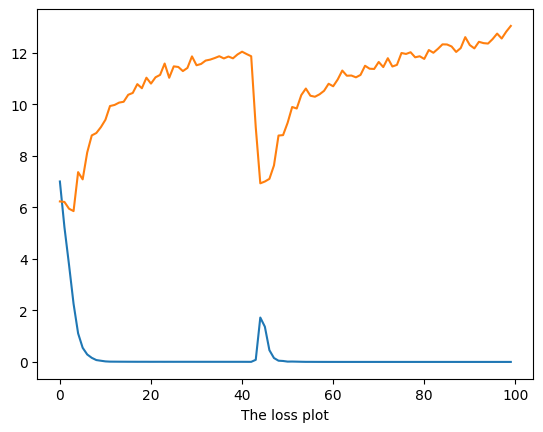

In [18]:
import matplotlib.pyplot as plt
plt.plot(df.train_loss)
plt.plot(df.val_loss)
plt.xlabel(f"The loss plot")
plt.show()

In [22]:
# train.to_csv("train.csv", index=False)
# val.to_csv("val.csv", index=False)

# Evaluation

In [32]:
model.load_state_dict(torch.load("models/best_RoBERTa.pt")['model'])
model.cuda();

RoBERTa(
  (RoBERTa): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

In [24]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

In [25]:
train_encodings = tokenizer(list(train.context), list(train.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

val_encodings = tokenizer(list(val.context), list(val.question), max_length=512, truncation=True, padding='max_length', return_tensors='pt')

In [28]:
add_token_positions(train_encodings, train)
add_token_positions(val_encodings, val)

In [29]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=True)

In [45]:
start_positions_, end_positions_ = [], []
target_start_positions_, target_end_positions_ = [], []

model.eval()
with torch.no_grad():
    loop = tqdm(val_loader)
    loss_list, count = 0, 0
    for batch in loop:            
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        
        for start in outputs['start_logits'].argmax(dim=1):
            start_positions_.append(start.cpu().item())
        for end in outputs['end_logits'].argmax(dim=1):
            end_positions_.append(end.cpu().item())
            
        for start in start_positions:
            target_start_positions_.append(start.cpu().item())
        for end in end_positions:
            target_end_positions_.append(end.cpu().item())
        

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]C:\Users\yerda\AppData\Local\Temp\ipykernel_15700\2881824031.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[x]) for key, val in self.encodings.items()}
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:02<00:00,  8.38it/s]


In [48]:
validation_results = pd.DataFrame({
    "predicted_start_positions": start_positions_,
    "predicted_end_posiitons": end_positions_,
    "target_start_positions": target_start_positions_,
    "target_end_positions": target_end_positions_,
})
# validation_results.to_csv("validation_results.csv", index=False)

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(validation_results['predicted_start_positions'], validation_results['target_start_positions'])

0.2865853658536585

In [53]:
accuracy_score(validation_results['predicted_end_posiitons'], validation_results['target_end_positions'])

0.1951219512195122

In [ ]:
28.65% 19.51%